Feature engineering

In [7]:
# Import core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Imbalance handling
from imblearn.over_sampling import SMOTE

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')



In [8]:
# Filepaths (update if needed)
fraud_path = "../data/processed/fraud_data_with_country.csv"

# Load
fraud_df = pd.read_csv(fraud_path)


# Show shapes
print("Fraud Data:", fraud_df.shape)



Fraud Data: (151112, 14)


after
   user_id         signup_time       purchase_time  purchase_value  \
0    62421 2015-02-16 00:17:05 2015-03-08 10:00:39              46   
1   173212 2015-03-08 04:03:22 2015-03-20 17:23:45              33   
2   242286 2015-05-17 16:45:54 2015-05-26 08:54:34              33   
3   370003 2015-03-03 19:58:39 2015-05-28 21:09:13              33   
4   119824 2015-03-20 00:31:27 2015-04-05 07:31:46              55   

       device_id  source  browser sex  age  class         ip_num    country  \
0  ZCLZTAJPCRAQX  Direct   Safari   M   36      0   52093.496895  Australia   
1  YFGYOALADBHLT     Ads       IE   F   30      0   93447.138961  Australia   
2  QZNVQTUITFTHH  Direct  FireFox   F   32      0  105818.501505  Australia   
3  PIBUQMBIELMMG     Ads       IE   M   40      0  117566.664867  Australia   
4  WFIIFCPIOGMHT     Ads   Safari   M   38      0  131423.789042  Australia   

        lower     upper  hour_of_day  day_of_week  time_since_signup  \
0  16777216.0  16777471   

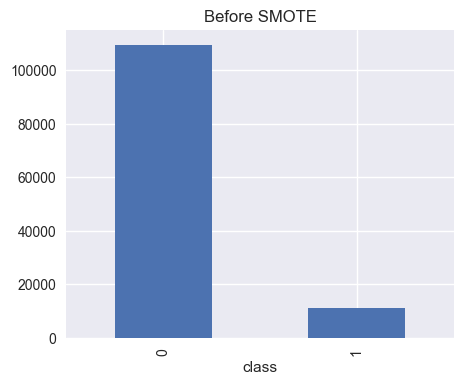


Class Distribution After SMOTE:
{np.int64(0): np.int64(109568), np.int64(1): np.int64(109568)}


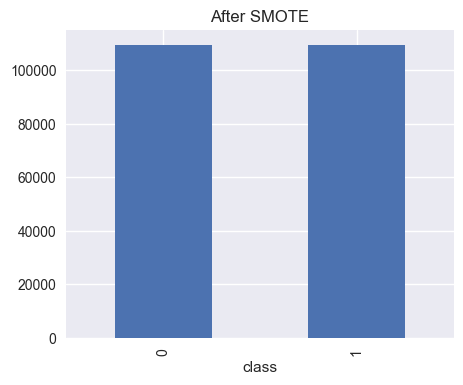

In [11]:
# -----------------------------
# FEATURE ENGINEERING + TRANSFORMATION + SMOTE
# -----------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

# ---------------------------------
# 1) FEATURE ENGINEERING
# ---------------------------------

# Make sure datetime columns are datetime dtypes
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Time-based features
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (
    fraud_df['purchase_time'] - fraud_df['signup_time']
).dt.total_seconds()
# Print first 5 rows with all columns
# print("Before")
# print(fraud_df.head())

# Transaction frequency / velocity
fraud_df['user_txn_count'] = fraud_df.groupby('user_id')['purchase_time'].transform('count')
fraud_df['device_txn_count'] = fraud_df.groupby('device_id')['purchase_time'].transform('count')
print("after")
# Print first 5 rows with all columns
print(fraud_df.head())

# ---------------------------------
# 2) SELECT FEATURES & TARGET
# ---------------------------------

X = fraud_df.drop(columns=['class'])
y = fraud_df['class']

# ---------------------------------
# 3) TRAIN/TEST SPLIT (STRATIFIED)
# ---------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# ---------------------------------
# 4) IDENTIFY CATEGORICAL & NUMERIC COLUMNS
# ---------------------------------

cat_cols = ['source', 'browser', 'sex']
num_cols = [
    'purchase_value',
    'age',
    'hour_of_day',
    'day_of_week',
    'time_since_signup',
    'user_txn_count',
    'device_txn_count'
]

# ---------------------------------
# 5) BUILD PREPROCESSING PIPELINE
# ---------------------------------

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocess = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# ---------------------------------
# 6) BEFORE RESAMPLING CLASS DISTRIBUTION
# ---------------------------------

print("Class Distribution Before SMOTE:")
print(y_train.value_counts())

plt.figure(figsize=(5,4))
y_train.value_counts().plot(kind='bar', title='Before SMOTE')
plt.show()

# ---------------------------------
# 7) APPLY SMOTE ON TRAINING SET ONLY
# ---------------------------------

# 1) Fit & transform training features
X_train_preprocessed = preprocess.fit_transform(X_train)

# 2) Oversample using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# ---------------------------------
# 8) AFTER RESAMPLING CLASS DISTRIBUTION
# ---------------------------------

print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(dict(zip(unique, counts)))

plt.figure(figsize=(5,4))
pd.Series(y_train_resampled).value_counts().plot(kind='bar', title='After SMOTE')
plt.show()
